###Initializing imports and data

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import torch
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.autograd import Variable

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


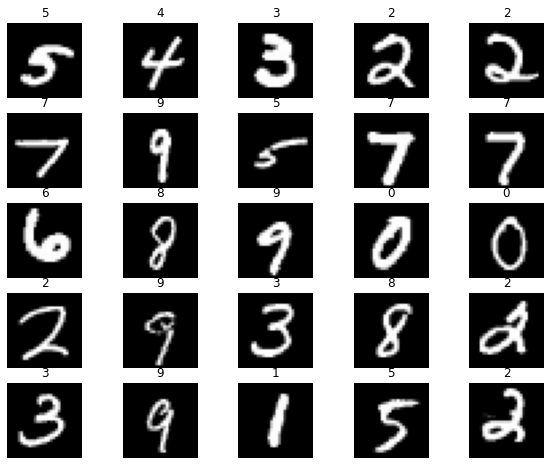

In [3]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

###Using MLPClassifier from Sklearn

In [4]:
X_train = np.reshape(train_data.data, (60000, 784))
y_train = train_data.targets
X_train = X_train/255
X_test = np.reshape(test_data.data, (10000, 784))
y_test = test_data.targets

In [5]:
mlp = MLPClassifier(hidden_layer_sizes=(50, ), max_iter=10, alpha=1e-4, 
                    solver='sgd', verbose=10, random_state=1, learning_rate_init=.1)

In [6]:
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.32009978
Iteration 2, loss = 0.15347534
Iteration 3, loss = 0.11544755
Iteration 4, loss = 0.09279764
Iteration 5, loss = 0.07889367
Iteration 6, loss = 0.07170497
Iteration 7, loss = 0.06282111
Iteration 8, loss = 0.05530788
Iteration 9, loss = 0.04960484
Iteration 10, loss = 0.04645355


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='constant',
              learning_rate_init=0.1, max_fun=15000, max_iter=10, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=10, warm_start=False)

In [7]:
print(f"Training set score: {mlp.score(X_train, y_train):.3f}")
print(f"Test set score: {mlp.score(X_test, y_test):.3f}")

Training set score: 0.987
Test set score: 0.967


###Train using a CNN with PyTorch

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1)



In [9]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
    self.act2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(2)
    self.out = nn.Linear(32 * 7 * 7, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.act2(x)
    x = self.pool2(x)
    
    x = x.view(x.size(0), -1)       
    output = self.out(x)
    return output, x

In [10]:
net = Net()


In [11]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.001)

In [12]:
def train(net, data, epochs, criterion, optim):
  net.train()
  total_batches = len(data)
  for epoch in range(epochs):
    for i, (image, target) in enumerate(data):
      xb = Variable(image)
      yb = Variable(target)

      predicts = net(xb)[0]
      loss = criterion(predicts, yb)
      optim.zero_grad()
      loss.backward()
      optim.step()

      if (i+1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{total_batches}], Loss: { loss.item():.4f}')

In [13]:
train(net, train_loader, 1, criterion, optim)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/1], Step [100/600], Loss: 0.3075
Epoch [1/1], Step [200/600], Loss: 0.1331
Epoch [1/1], Step [300/600], Loss: 0.1085
Epoch [1/1], Step [400/600], Loss: 0.1520
Epoch [1/1], Step [500/600], Loss: 0.0587
Epoch [1/1], Step [600/600], Loss: 0.1140


In [14]:
def test(net, data):
  net.eval()

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in data:
      predict, last_layer = net(images)
      pred_y = torch.max(predict, 1)[1].data.squeeze()
      accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
    
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

In [15]:
test(net, test_loader)

Test Accuracy of the model on the 10000 test images: 0.95


In [16]:
sample = next(iter(test_loader))
imgs, lbls = sample

actual_number = lbls[:10].numpy()

test_output, last_layer = net(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [5 8 9 1 9 6 6 2 4 9]
Actual number: [5 8 9 1 9 6 6 2 4 9]
